In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

E:\anaconda3\envs\jcopml2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Import data

In [2]:
df = pd.read_csv("data/carprice.csv", index_col="ID")
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
ID,,,,,,,,,,,,
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50


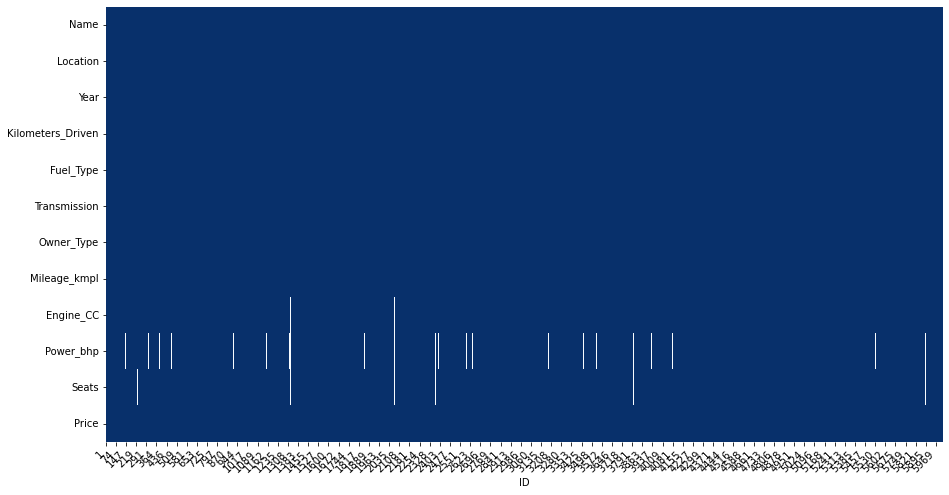

In [3]:
plot_missing_value(df)

In [4]:
df.isnull().sum()

Name                   0
Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage_kmpl           2
Engine_CC             36
Power_bhp            142
Seats                 42
Price                  0
dtype: int64

In [5]:
df.drop(columns='Name', inplace=True)

# Dataset Splitting

In [6]:
X = df.drop(columns="Price")
y = df.Price


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4762, 10), (1191, 10), (4762,), (1191,))

# Training

In [7]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [8]:
X_train.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats
ID,,,,,,,,,,
4380,Coimbatore,2016,60913,Petrol,Manual,First,20.73,1373.0,91.1,5.0
2676,Kochi,2017,40459,Diesel,Manual,First,19.67,1582.0,126.2,5.0
647,Jaipur,2004,200000,Petrol,Manual,First,0.00,1086.0,NaN,5.0
5966,Hyderabad,2018,1048,Petrol,Manual,First,18.90,998.0,67.1,5.0
2198,Ahmedabad,2013,96000,Diesel,Manual,Second,23.50,1498.0,90.0,5.0


In [9]:
X_train.Seats.value_counts()

5.0     3946
7.0      545
8.0      111
4.0       74
6.0       28
2.0       15
10.0       4
9.0        3
Name: Seats, dtype: int64

In [10]:
gsp.svm_params

{'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [11]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["Year", "Kilometers_Driven", "Mileage_kmpl", "Engine_CC", "Power_bhp", "Seats"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location", "Fuel_Type", "Transmission", "Owner_Type"]),
])



pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


E:\anaconda3\envs\jcopml2\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


{'algo__C': 10.0, 'algo__gamma': 0.001}
0.4191924234077009 0.08719422320538917 0.055845667362476537



# Scaling can help SVM and KNN

In [12]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ["Year", "Kilometers_Driven", "Mileage_kmpl", "Engine_CC", "Power_bhp", "Seats"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location", "Fuel_Type", "Transmission", "Owner_Type"]),
])



pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


E:\anaconda3\envs\jcopml2\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.8595035899603412 0.8331947362805839 0.8197066934420881


# Polynomial Features

In [1]:
from luwiji.svm import demo

In [2]:
demo.poly_features()

interactive(children=(ToggleButtons(description='degree', options=(1, 2, 3), value=1), Checkbox(value=False, d…

In [15]:
gsp.svm_poly_params

{'prep__numeric__poly__degree': [1, 2, 3],
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [17]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2 ,scaling='standard'), ["Year", "Kilometers_Driven", "Mileage_kmpl", "Engine_CC", "Power_bhp", "Seats"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location", "Fuel_Type", "Transmission", "Owner_Type"]),
])



pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model = GridSearchCV(pipeline, gsp.svm_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 294 candidates, totalling 882 fits


E:\anaconda3\envs\jcopml2\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


{'algo__C': 10.0, 'algo__gamma': 0.1, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.8595035899603423 0.8331947362805844 0.8197066934420865


In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2 ,scaling='standard'), ["Year", "Kilometers_Driven", "Mileage_kmpl", "Engine_CC", "Power_bhp", "Seats"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location", "Fuel_Type", "Transmission", "Owner_Type"]),
])



pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model = GridSearchCV(pipeline, gsp.svm_prep_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

# Save Model

In [ ]:
save_model(model.best_estimator_, "car_price.pkl")